<a href="https://colab.research.google.com/github/kkorhone/Python_Notebooks/blob/main/jtf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pygfunction

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.6 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
import scipy.signal
import pygfunction
import numpy as np

In [12]:
def calc(monthly_fraction):

    assert np.abs(np.sum(monthly_fraction) - 1) < 1e-6

    T_surface = 6.1                         # [degC]
    q_geothermal = 0.053                    # [W/m^2]

    k_rock = 3.84                           # [W/(m*K)]
    Cp_rock = 728.0                         # [J/(kg*K)]
    rho_rock = 2619.0                       # [kg/m^3]

    R_borehole = 0.085                      # [K/(W/m)]

    L_borehole = 600.0                      # [m]
    r_borehole = 0.140 / 2                  # [m]

    num_years = 25                          # [1]

    T_target = -1.0                         # [degC]

    a_rock = k_rock / (rho_rock * Cp_rock)  # [m^2/s]

    t_max = num_years * 365 * 24 * 3600.0   # [s]

    delta_t = 730 * 3600.0                  # [s]

    T_initial = T_surface + q_geothermal / k_rock * (0.5 * L_borehole)

    bhe = pygfunction.boreholes.Borehole(H=L_borehole, D=0, r_b=r_borehole, x=0, y=0)

    t = pygfunction.utilities.time_geometric(delta_t, t_max, 50)
    g = pygfunction.gfunction.uniform_temperature([bhe], t, a_rock, nSegments=32, disp=True)

    ti = np.arange(delta_t, t_max+delta_t, delta_t)
    gi = scipy.interpolate.interp1d(t, g)(ti)

    def evaluate_mean_fluid_temperatures(E_annual):

        monthly_heat_load = E_annual * monthly_fraction

        heat_rate = np.ravel(np.tile(monthly_heat_load*1_000_000/730.0, (1, num_years)))

        specific_heat_rate = heat_rate / L_borehole
        delta_q = np.hstack((-specific_heat_rate[0], np.diff(-specific_heat_rate)))

        T_wall = T_initial + scipy.signal.fftconvolve(delta_q, gi/(2.0*np.pi*k_rock), mode="full")[:len(ti)]
        T_fluid = T_wall - R_borehole * specific_heat_rate

        return T_fluid

    def cost_function(annual_heat_load):

        T_fluid = evaluate_mean_fluid_temperatures(annual_heat_load)

        return np.abs(np.min(T_fluid) - T_target)

    annual_heat_load = scipy.optimize.fminbound(cost_function, 1, 1000, xtol=0.001)

    T_fluid = evaluate_mean_fluid_temperatures(annual_heat_load)

    plt.figure()
    plt.plot(ti/(365*24*3600), T_fluid)
    plt.axhline(T_target, ls="--", color="k")
    plt.xlabel("Year")
    plt.ylabel(u"Mean fluid temperature [\xb0C]")
    plt.title(f"annual_heat_load = {annual_heat_load:.3f} MWh")

Identifying similarities ... 0.000 sec
------------------------------------------------------------
   Calculating g-function for boundary condition : 'UBWT'   
------------------------------------------------------------
Calculating segment to segment response factors ... 2.494 sec
Building and solving the system of equations ... 0.049 sec
Total time for g-function evaluation: 2.548 sec
------------------------------------------------------------
Identifying similarities ... 0.000 sec
------------------------------------------------------------
   Calculating g-function for boundary condition : 'UBWT'   
------------------------------------------------------------
Calculating segment to segment response factors ... 2.500 sec
Building and solving the system of equations ... 0.051 sec
Total time for g-function evaluation: 2.555 sec
------------------------------------------------------------
Identifying similarities ... 0.000 sec
---------------------------------------------------------

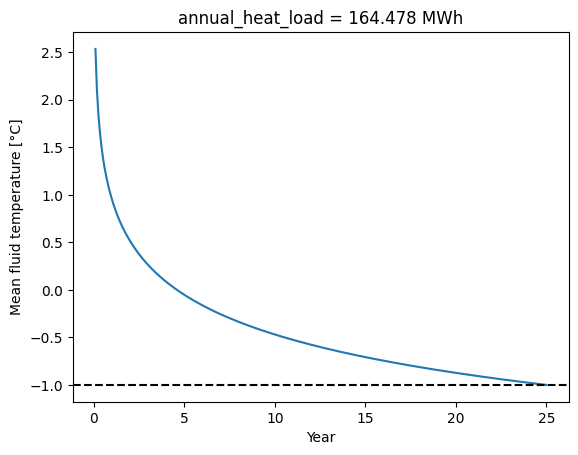

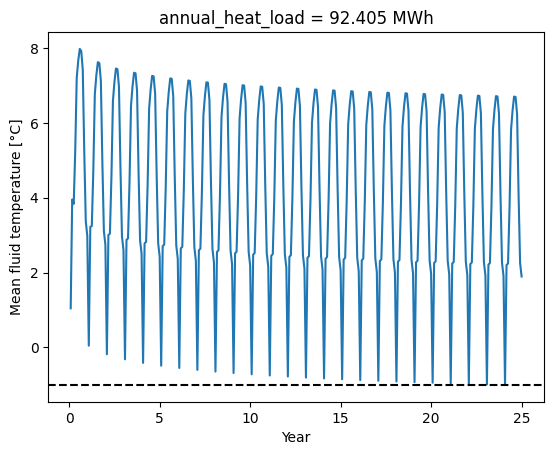

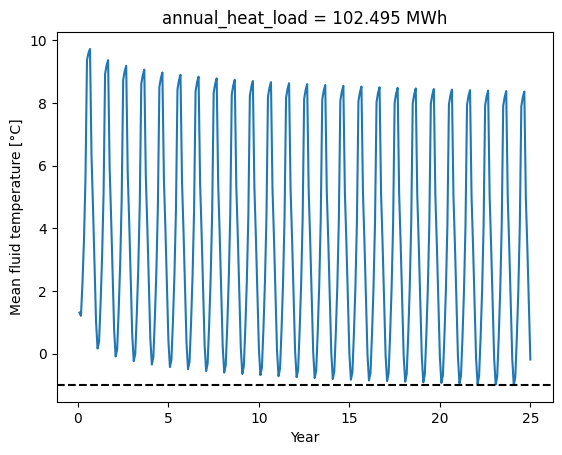

In [13]:
if __name__ == "__main__":
    calc(np.ones(12)/12)
    calc(np.array([0.177,0.111,0.111,0.082,0.044,0.037,0.032,0.034,0.044,0.086,0.119,0.123]))
    calc(np.array([0.155,0.148,0.125,0.099,0.064,0.000,0.000,0.000,0.061,0.087,0.117,0.144]))